In [1]:
import pandas as pd
import numpy as np
import pickle
import spacy
import time

In [47]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
#!pip install spacy

In [3]:
#!python -m spacy download ru_core_news_lg

### Checkpoint

In [5]:
save_frame = pd.read_pickle('embeddings_1_17_33_45_58_81_86.pickle')

In [19]:
save_frame = save_frame[(save_frame['1_step']==1)|(save_frame['1_step']==17)|(save_frame['1_step']==33)].copy()
save_frame

,text,OKPD2,1_step,1.5_steps,2_steps,2.5_steps,3_steps,4_steps,embedding,predicted_1_step
0,укроп свежий,01.13.19.000,1,11,113,1131,11319,11319000,"[0.3195403, -0.32790005, -0.06497962, 0.349259...",11
1,яблоки,01.24.10.000,1,12,124,1241,12410,12410000,"[-0.20394225, -0.5428032, 0.17268088, -0.27738...",12
2,капуста брокколи,01.13.13.000,1,11,113,1131,11313,11313000,"[0.34785545, 0.1356812, 0.1781406, -0.40813398...",11
3,морковь столовая,01.13.41.110,1,11,113,1134,11341,11341110,"[0.4754958, 0.10029624, 0.0036270898, 0.009132...",11
4,яйца куриные в скорлупе свежие,01.47.21.000,1,14,147,1472,14721,14721000,"[-0.34016472, -0.03254654, -0.046401866, 0.246...",14
...,...,...,...,...,...,...,...,...,...,...
4092102,ап-т квч трехчастотный 161310 (2010),33.13.12.000,33,331,3313,33131,331312,331312000,"[-0.016549775, -0.09976013, 0.0001532634, -0.0...",331
4092103,услуга по замене (работа) единицы оборудования...,33.12.29.900,33,331,3312,33122,331229,331229900,"[0.076836, 0.0043391306, -0.07767383, -0.07636...",331
4092104,техническое обслуживание и ремонт систем контр...,33.12.19.000,33,331,3312,33121,331219,331219000,"[0.058661614, -0.11064894, -0.17567627, 0.0260...",331
4092105,услуги технического сопровождения систем бумаж...,33.12.16.000,33,331,3312,33121,331216,331216000,"[-0.013584461, -0.109105244, -0.0005458418, -0...",331


### Предсказываем 1.5 ступени

In [8]:
labels = save_frame[['1_step', '1.5_steps',	'2_steps', '2.5_steps',	'3_steps',	'4_steps']]

In [9]:
set(list(labels['1.5_steps']))

{11, 12, 13, 14, 16, 17, 171, 172, 331, 332}

Разбиение выборки на train и test

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(list(save_frame['embedding']), list(labels['1.5_steps']), test_size=0.2, random_state=42)

Лог регрессия из sklearn

In [12]:
start_time = time.time()
model = LogisticRegression(multi_class='ovr', solver ='newton-cg' )
model.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 725.3615329265594 seconds ---


Построение ROC кривой

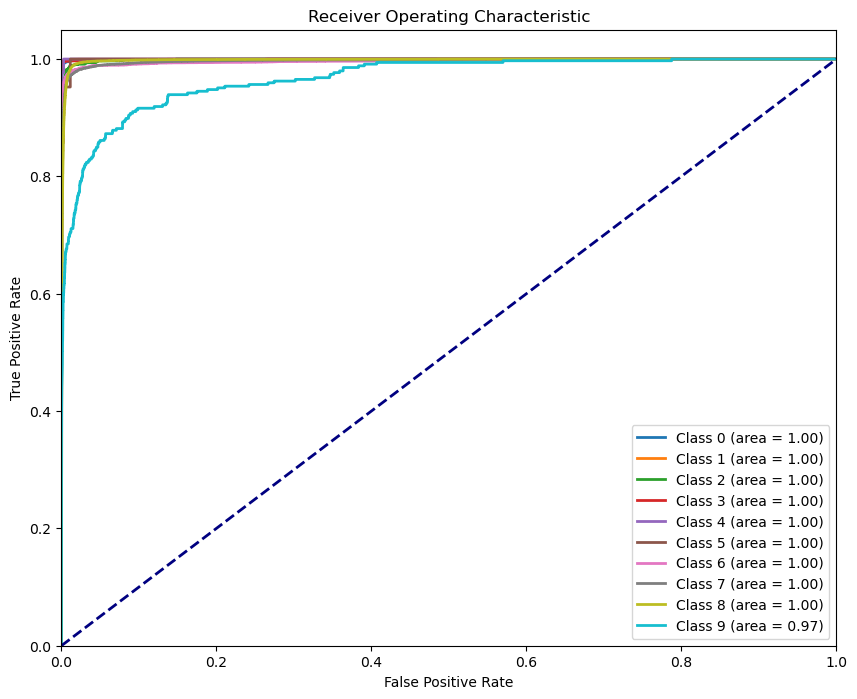

In [14]:
# Бинаризация меток для многоклассовой классификации
y_test_binarized = label_binarize(y_test, classes=np.unique(labels['1.5_steps']))

# Предсказание вероятностей для всех классов
y_score = model.predict_proba(X_test)

# Вычисление параметров ROC-кривых для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение ROC-кривых для всех классов
plt.figure(figsize=(10, 8))

classes_to_see = [0,1, 2, 3]
for i in range(y_test_binarized.shape[1]): # range(y_test_binarized.shape[1])
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



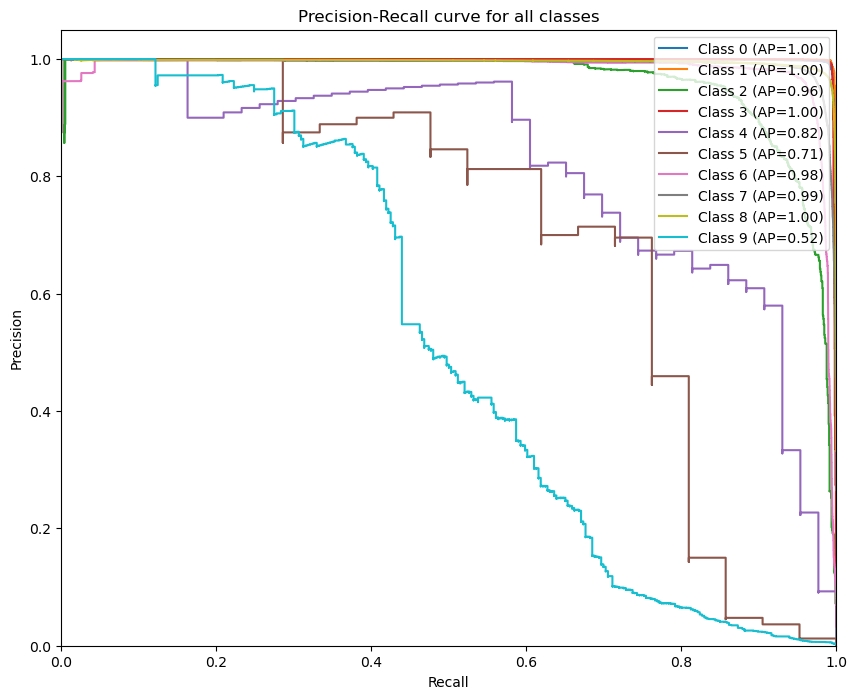

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Расчет кривых точности и полноты для каждого класса
precision = dict()
recall = dict()
average_precision = dict()
for i in range(y_test_binarized.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])

# Построение графиков кривых точности-полноты для всех классов
plt.figure(figsize=(10, 8))
for i in range(y_test_binarized.shape[1]):
    plt.step(recall[i], precision[i], where='post', 
             label='Class {} (AP={:.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for all classes')
plt.legend(loc="upper right")
plt.show()


In [16]:
model_classes = model.classes_
print(model_classes)

[ 11  12  13  14  16  17 171 172 331 332]


In [23]:
save_frame['predicted_1.5_steps'] = model.predict(list(save_frame['embedding']))
save_frame.head()

,text,OKPD2,1_step,1.5_steps,2_steps,2.5_steps,3_steps,4_steps,embedding,predicted_1.5_steps
0,укроп свежий,01.13.19.000,1,11,113,1131,11319,11319000,"[0.3195403, -0.32790005, -0.06497962, 0.349259...",11
1,яблоки,01.24.10.000,1,12,124,1241,12410,12410000,"[-0.20394225, -0.5428032, 0.17268088, -0.27738...",12
2,капуста брокколи,01.13.13.000,1,11,113,1131,11313,11313000,"[0.34785545, 0.1356812, 0.1781406, -0.40813398...",11
3,морковь столовая,01.13.41.110,1,11,113,1134,11341,11341110,"[0.4754958, 0.10029624, 0.0036270898, 0.009132...",11
4,яйца куриные в скорлупе свежие,01.47.21.000,1,14,147,1472,14721,14721000,"[-0.34016472, -0.03254654, -0.046401866, 0.246...",14
...,...,...,...,...,...,...,...,...,...,...
4092102,ап-т квч трехчастотный 161310 (2010),33.13.12.000,33,331,3313,33131,331312,331312000,"[-0.016549775, -0.09976013, 0.0001532634, -0.0...",331
4092103,услуга по замене (работа) единицы оборудования...,33.12.29.900,33,331,3312,33122,331229,331229900,"[0.076836, 0.0043391306, -0.07767383, -0.07636...",331
4092104,техническое обслуживание и ремонт систем контр...,33.12.19.000,33,331,3312,33121,331219,331219000,"[0.058661614, -0.11064894, -0.17567627, 0.0260...",331
4092105,услуги технического сопровождения систем бумаж...,33.12.16.000,33,331,3312,33121,331216,331216000,"[-0.013584461, -0.109105244, -0.0005458418, -0...",331


#### Анализ ошибок

In [26]:
print(save_frame[save_frame['1.5_steps']!=save_frame['predicted_1.5_steps']].shape)
save_frame[save_frame['1.5_steps']!=save_frame['predicted_1.5_steps']].groupby('1.5_steps')['text'].count()

(16432, 10)


1.5_steps
11     1467
12      434
13     1157
14      244
16      116
17       67
171    3030
172    5579
331    3112
332    1226
Name: text, dtype: int64

In [27]:
save_frame.groupby('1.5_steps')['text'].count()

1.5_steps
11     147693
12      64291
13       7793
14      23871
16        247
17        102
171     51112
172    195065
331    244877
332      1679
Name: text, dtype: int64

плохо распознаются 332 и 13 классы, у них много больших соседей и классификатору тяжело  

  - 332 = 	Услуги по монтажу промышленных машин и оборудования  244877 записей  - 
33 = Услуги по ремонту металлоизделий, машин и оборудования  1679 записей
  - 
1  = Материалы растительные: растения живые; луковицы, клубнелуковицы и корневища; отводки и черенки; грибницы
  - 
1  = Культуры однолетние
  - 
1  = Культуры многолетние
  - 
1  = Животные живые и продукты животного происхождения
  - Не понимаю почему в конце строки выведется 4отных....
  - 4отных


In [28]:
save_frame[save_frame['1.5_steps']==332]

,text,OKPD2,1_step,1.5_steps,2_steps,2.5_steps,3_steps,4_steps,embedding,predicted_1.5_steps
3842505,выполнение работ по монтажу системы видеонаблю...,33.20.42.000,33,332,3320,33204,332042,332042000,"[-0.06473208, -0.078665264, -0.1935217, 0.0542...",332
3842544,услуги по монтажу прочего оборудования специал...,33.20.39.900,33,332,3320,33203,332039,332039900,"[-0.022526741, -0.1471238, -0.14960934, -0.083...",332
3842579,выполнение работ по модернизации системы контр...,33.20.39.900,33,332,3320,33203,332039,332039900,"[0.04538506, -0.08777293, -0.0590436, 0.038707...",331
3842756,"""коммутатор служебной связи""\r\n\r\n\r\n",33.20.42.000,33,332,3320,33204,332042,332042000,"[-0.021546895, -0.05358979, 0.034469556, 0.055...",331
3842896,замена ограничителя открытия платформы,33.20.39.900,33,332,3320,33203,332039,332039900,"[-0.07781919, -0.11666022, 0.004372135, -0.105...",331
...,...,...,...,...,...,...,...,...,...,...
4091674,"присоединение энергопринимающего устройства, у...",33.20.39.900,33,332,3320,33203,332039,332039900,"[0.086344056, 0.13224623, 0.08405509, 0.039801...",332
4091733,монтаж системы видеонаблюдения,33.20.39.900,33,332,3320,33203,332039,332039900,"[-0.020508012, -0.0019521316, -0.12099469, -0....",332
4091754,выполнение работ по праздничному оформлению те...,33.20.70.000,33,332,3320,33207,332070,332070000,"[0.088666536, -0.10939376, -0.04956862, 0.1686...",172
4091996,оказание услуг по монтажу и демонтажу элементо...,33.20.70.000,33,332,3320,33207,332070,332070000,"[0.045724086, 0.18756634, -0.0355443, -0.03235...",331


### Иерархичная классификация - для каждого класса 1.5 ступени отдельно классификатор строим для предсказания 2.5_steps

#### Предсказываем зная 1.5 -> 2.5

In [30]:
unique_classes = save_frame['predicted_1.5_steps'].unique()
classifiers = {}
unique_classes

array([ 11,  12,  14,  13, 172, 331,  16, 171,  17, 332])

In [31]:
for class_ in unique_classes:
    # Выборка подгруппы данных для текущего класса
    subgroup = save_frame[save_frame['predicted_1.5_steps'] == class_]
    X_subgroup = list(subgroup['embedding'])
    y_subgroup = subgroup['2.5_steps']  # какой уровень классификации хотим предсказать
    
    # Разделение подгруппы на обучающую и тестовую выборки
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_subgroup, y_subgroup, test_size=0.1, random_state=42)
    
    # Обучение классификатора для подгруппы
    model_sub = LogisticRegression(multi_class='ovr', solver='newton-cg')
    model_sub.fit(X_train_sub, y_train_sub)
    
    # Сохранение обученного классификатора в словаре
    classifiers[class_] = model_sub


In [32]:
def predict_class(row, classifiers_dict):
    # Получаем классификатор для предсказанного класса
    classifier = classifiers_dict[row['predicted_1.5_steps']]
    return classifier.predict([row['embedding']])[0]

save_frame['predicted_2.5_steps'] = save_frame.apply(lambda row: predict_class(row, classifiers), axis=1)
save_frame.head()

,text,OKPD2,1_step,1.5_steps,2_steps,2.5_steps,3_steps,4_steps,embedding,predicted_1.5_steps,predicted_2.5_steps
0,укроп свежий,01.13.19.000,1,11,113,1131,11319,11319000,"[0.3195403, -0.32790005, -0.06497962, 0.349259...",11,1131
1,яблоки,01.24.10.000,1,12,124,1241,12410,12410000,"[-0.20394225, -0.5428032, 0.17268088, -0.27738...",12,1241
2,капуста брокколи,01.13.13.000,1,11,113,1131,11313,11313000,"[0.34785545, 0.1356812, 0.1781406, -0.40813398...",11,1131
3,морковь столовая,01.13.41.110,1,11,113,1134,11341,11341110,"[0.4754958, 0.10029624, 0.0036270898, 0.009132...",11,1134
4,яйца куриные в скорлупе свежие,01.47.21.000,1,14,147,1472,14721,14721000,"[-0.34016472, -0.03254654, -0.046401866, 0.246...",14,1472
...,...,...,...,...,...,...,...,...,...,...,...
4092102,ап-т квч трехчастотный 161310 (2010),33.13.12.000,33,331,3313,33131,331312,331312000,"[-0.016549775, -0.09976013, 0.0001532634, -0.0...",331,33121
4092103,услуга по замене (работа) единицы оборудования...,33.12.29.900,33,331,3312,33122,331229,331229900,"[0.076836, 0.0043391306, -0.07767383, -0.07636...",331,33122
4092104,техническое обслуживание и ремонт систем контр...,33.12.19.000,33,331,3312,33121,331219,331219000,"[0.058661614, -0.11064894, -0.17567627, 0.0260...",331,33122
4092105,услуги технического сопровождения систем бумаж...,33.12.16.000,33,331,3312,33121,331216,331216000,"[-0.013584461, -0.109105244, -0.0005458418, -0...",331,33121


In [33]:
print(save_frame[save_frame['2.5_steps']!=save_frame['predicted_2.5_steps']].shape)
save_frame[save_frame['2.5_steps']!=save_frame['predicted_2.5_steps']].groupby('2.5_steps')['text'].count()

(101914, 11)


2.5_steps
1116       191
1117        58
1119         3
1131       261
1133       159
1134       221
1135       110
1138         2
1139       848
1192       781
1193        43
1211         3
1221        96
1231        94
1241        77
1242        56
1251        28
1253         3
1281       184
1301       674
1412         9
1472        56
1491        17
1492       126
1611        75
1701        55
17121     2053
17124      270
17125      120
17127      319
17211      624
17221      676
17229      226
17231     3749
17239      246
17241       23
17291     2840
17299      185
33111      512
33121    19398
33122    26525
33131    17871
33141     8070
33151     3649
33161      714
33171     5703
33191     2783
33202      236
33203      262
33204      377
33205       97
33207      156
Name: text, dtype: int64

In [34]:
save_frame.groupby('2.5_steps')['text'].count()

2.5_steps
1116        267
1117      12545
1119        110
1131      24916
1133      19510
1134      61949
1135      19363
1138        146
1139        992
1192       7485
1193        410
1211        552
1221       8320
1231      22608
1241      17133
1242       7870
1251       7319
1253        266
1281        223
1301       7793
1412        148
1472      22857
1491        392
1492        474
1611        247
1701        102
17121     49488
17124       435
17125       121
17127      1068
17211      1531
17221     30618
17229       271
17231    158759
17239       246
17241       155
17291      3296
17299       189
33111       540
33121     70501
33122     41729
33131     73797
33141      8878
33151      4826
33161       743
33171     39730
33191      4133
33202       239
33203       732
33204       436
33205       101
33207       171
Name: text, dtype: int64

#### Пробуем для 3 ступени

In [35]:
start_time = time.time()
classifiers1 = {}
for class_ in unique_classes:
    # Выборка подгруппы данных для текущего класса
    subgroup1 = save_frame[save_frame['predicted_1.5_steps'] == class_]
    X_subgroup1 = list(subgroup1['embedding'])
    y_subgroup1 = subgroup1['3_steps']  # какой уровень классификации хотим предсказать
    
    # Разделение подгруппы на обучающую и тестовую выборки
    X_train_sub1, X_test_sub1, y_train_sub1, y_test_sub1 = train_test_split(X_subgroup1, y_subgroup1, test_size=0.1, random_state=42)
    
    # Обучение классификатора для подгруппы
    model_sub1 = LogisticRegression(multi_class='ovr', solver='newton-cg')
    model_sub1.fit(X_train_sub1, y_train_sub1)
    
    # Сохранение обученного классификатора в словаре
    classifiers1[class_] = model_sub1
print("--- %s seconds ---" % (time.time() - start_time))

--- 3783.9622044563293 seconds ---


In [36]:
save_frame['predicted_3_steps'] = save_frame.apply(lambda row: predict_class(row, classifiers1), axis=1)
save_frame

,text,OKPD2,1_step,1.5_steps,2_steps,2.5_steps,3_steps,4_steps,embedding,predicted_1.5_steps,predicted_2.5_steps,predicted_3_steps
0,укроп свежий,01.13.19.000,1,11,113,1131,11319,11319000,"[0.3195403, -0.32790005, -0.06497962, 0.349259...",11,1131,11319
1,яблоки,01.24.10.000,1,12,124,1241,12410,12410000,"[-0.20394225, -0.5428032, 0.17268088, -0.27738...",12,1241,12410
2,капуста брокколи,01.13.13.000,1,11,113,1131,11313,11313000,"[0.34785545, 0.1356812, 0.1781406, -0.40813398...",11,1131,11313
3,морковь столовая,01.13.41.110,1,11,113,1134,11341,11341110,"[0.4754958, 0.10029624, 0.0036270898, 0.009132...",11,1134,11341
4,яйца куриные в скорлупе свежие,01.47.21.000,1,14,147,1472,14721,14721000,"[-0.34016472, -0.03254654, -0.046401866, 0.246...",14,1472,14721
...,...,...,...,...,...,...,...,...,...,...,...,...
4092102,ап-т квч трехчастотный 161310 (2010),33.13.12.000,33,331,3313,33131,331312,331312000,"[-0.016549775, -0.09976013, 0.0001532634, -0.0...",331,33121,331719
4092103,услуга по замене (работа) единицы оборудования...,33.12.29.900,33,331,3312,33122,331229,331229900,"[0.076836, 0.0043391306, -0.07767383, -0.07636...",331,33122,331229
4092104,техническое обслуживание и ремонт систем контр...,33.12.19.000,33,331,3312,33121,331219,331219000,"[0.058661614, -0.11064894, -0.17567627, 0.0260...",331,33122,331229
4092105,услуги технического сопровождения систем бумаж...,33.12.16.000,33,331,3312,33121,331216,331216000,"[-0.013584461, -0.109105244, -0.0005458418, -0...",331,33121,331216


In [37]:
print(save_frame[save_frame['3_steps']!=save_frame['predicted_3_steps']].shape)
save_frame[save_frame['3_steps']!=save_frame['predicted_3_steps']].groupby('3_steps')['text'].count()

(112425, 12)


3_steps
11161      72
11162     120
11171      10
11174       4
11175      48
         ... 
332029    237
332039    264
332042    353
332050     97
332070    150
Name: text, Length: 103, dtype: int64

#### Анализ

Несколько сложно получить такие же графики Roc-кривой и presign-recall,  
как это было сделано в классическом варианте лог регрессии   
из-за того что по сути модель это совокупность классификаторов, и для них   
выборка на самом деле не ровно такая как была ранее в экспериментах  

Поэтому просто сравним качество классификации (со стандартным методом) по количеству ошибок для каждого класса  
результат - и для предсказания ступени 2.5 и для 3 - количество ошибок действительно меньше, но лишь незначитально, на ~5%

Выводы: Такая идея классификации незначительно улучшает результаты

#### на всякий случай с 1.5 на 2 посмотрим

In [40]:
classifiers2 = {}

In [41]:
for class_ in unique_classes:
    # Выборка подгруппы данных для текущего класса
    subgroup2 = save_frame[save_frame['predicted_1.5_steps'] == class_]
    X_subgroup2 = list(subgroup2['embedding'])
    y_subgroup2 = subgroup2['2_steps']  # какой уровень классификации хотим предсказать
    
    # Разделение подгруппы на обучающую и тестовую выборки
    X_train_sub2, X_test_sub2, y_train_sub2, y_test_sub2 = train_test_split(X_subgroup2, y_subgroup2, test_size=0.1, random_state=42)
    
    # Обучение классификатора для подгруппы
    model_sub2 = LogisticRegression(multi_class='ovr', solver='newton-cg')
    model_sub2.fit(X_train_sub2, y_train_sub2)
    
    # Сохранение обученного классификатора в словаре
    classifiers2[class_] = model_sub2


In [44]:
def predict_class(row, classifiers_dict):
    # Получаем классификатор для предсказанного класса
    classifier = classifiers_dict[row['predicted_1.5_steps']]
    return classifier.predict([row['embedding']])[0]

save_frame['predicted_2_steps'] = save_frame.apply(lambda row: predict_class(row, classifiers2), axis=1)
save_frame.head()

,text,OKPD2,1_step,1.5_steps,2_steps,2.5_steps,3_steps,4_steps,embedding,predicted_1.5_steps,predicted_2.5_steps,predicted_3_steps,predicted_2_steps
0,укроп свежий,01.13.19.000,1,11,113,1131,11319,11319000,"[0.3195403, -0.32790005, -0.06497962, 0.349259...",11,1131,11319,113
1,яблоки,01.24.10.000,1,12,124,1241,12410,12410000,"[-0.20394225, -0.5428032, 0.17268088, -0.27738...",12,1241,12410,124
2,капуста брокколи,01.13.13.000,1,11,113,1131,11313,11313000,"[0.34785545, 0.1356812, 0.1781406, -0.40813398...",11,1131,11313,113
3,морковь столовая,01.13.41.110,1,11,113,1134,11341,11341110,"[0.4754958, 0.10029624, 0.0036270898, 0.009132...",11,1134,11341,113
4,яйца куриные в скорлупе свежие,01.47.21.000,1,14,147,1472,14721,14721000,"[-0.34016472, -0.03254654, -0.046401866, 0.246...",14,1472,14721,147
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092102,ап-т квч трехчастотный 161310 (2010),33.13.12.000,33,331,3313,33131,331312,331312000,"[-0.016549775, -0.09976013, 0.0001532634, -0.0...",331,33121,331719,3312
4092103,услуга по замене (работа) единицы оборудования...,33.12.29.900,33,331,3312,33122,331229,331229900,"[0.076836, 0.0043391306, -0.07767383, -0.07636...",331,33122,331229,3312
4092104,техническое обслуживание и ремонт систем контр...,33.12.19.000,33,331,3312,33121,331219,331219000,"[0.058661614, -0.11064894, -0.17567627, 0.0260...",331,33122,331229,3312
4092105,услуги технического сопровождения систем бумаж...,33.12.16.000,33,331,3312,33121,331216,331216000,"[-0.013584461, -0.109105244, -0.0005458418, -0...",331,33121,331216,3312


In [45]:
print(save_frame[save_frame['2_steps']!=save_frame['predicted_2_steps']].shape)
save_frame[save_frame['2_steps']!=save_frame['predicted_2_steps']].groupby('2_steps')['text'].count()

(86415, 13)


2_steps
111        79
113       278
119       834
121         3
122        96
123        93
124       104
125        36
128       188
130       687
141         9
147        58
149       152
161        75
170        57
1712     2509
1721      645
1722      819
1723     3939
1724       23
1729     3031
3311      518
3312    20152
3313    28395
3314     8450
3315     3773
3316      718
3317     6761
3319     2867
3320     1066
Name: text, dtype: int64

**86к ошибок, в клссической версии 90, опять же ~5%** 